The objective of this assignment is to design and implement an in-memory spatial network index structure that is used in Spatial Network Databases (SNDB), following the framework presented in this paper: [Link to paper.](https://www.vldb.org/conf/2003/papers/S24P02.pdf)
To test and evaluate the performance of the index structure, implementations of the spatial nearest neighbor queries following the Incremental Euclidean Restriction (IER) and Incremental Network Expansion (INE) methods are used.

In [1]:
from random import sample

from networkx import edge_load_centrality
from osmnx.distance import euclidean
### Install dependencies

!pip install geopandas
!pip install osmnx
!pip install rtree


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Step 1- Download the POI and Road-Network Data for San Francisco Area


#### Download the Road Network data

We download the road network of San Fransisco using the osmnx package.

In [2]:
import osmnx as ox
import geopandas as gpd
import os
from shapely.geometry import Point, LineString

# Download data if not already stored
if not os.path.exists('sf-road_network.graphml'):

  # Specify area as San Francisco, CA
  G = ox.graph_from_place('San Francisco, California, USA', network_type='drive', simplify=True) # set to simplify=True for a less nodes

  # Plot the road network
  ox.plot_graph(G)

  # Save the graph
  ox.save_graph_shapefile(G)
  ox.save_graphml(G, filepath='sf-road_network.graphml')

else:

  # Load data from the file
  G = ox.load_graphml('sf-road_network.graphml')

# Extract the nodes and edges from the graph
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

print("Nodes columns:", nodes_gdf.columns)
print("Edges columns:", edges_gdf.columns)

Nodes columns: Index(['y', 'x', 'street_count', 'ref', 'highway', 'geometry'], dtype='object')
Edges columns: Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'bridge', 'tunnel', 'geometry', 'access',
       'junction', 'width'],
      dtype='object')


#### Download the POI data for San Francisco Area

Here, we make sure that the POIs are within the road network bounding box.

In [3]:
from shapely.geometry import box

# Chek if data is already stored
if not os.path.exists('sf-attractions.geojson'):

  tags = {'tourism': True, 'amenity': True}

  # Load tourist attractions in San Francisco
  attractions = ox.features.features_from_place('San Francisco, California, USA', tags)

  # Plot the tourist attractions
  attractions = attractions[['name', 'geometry']]
  attractions_gdf = gpd.GeoDataFrame(attractions, geometry='geometry')

  # Get the bounding box of the road network
  minx, miny, maxx, maxy = edges_gdf.total_bounds

  # Create a bounding box polygon
  bounding_box = box(minx, miny, maxx, maxy)

  # Convert the bounding box to a GeoDataFrame
  bounding_box_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'], crs=edges_gdf.crs)

  # Ensure the POIs and road network have the same Coordinate Reference System
  if attractions_gdf.crs != edges_gdf.crs:
      attractions_gdf = attractions_gdf.to_crs(edges_gdf.crs)

  # Filter the POIs to keep only those within the bounding box
  attractions_in_bbox = attractions_gdf[attractions_gdf.within(bounding_box)]

  # Drop non-Point geometries
  attractions_in_bbox = attractions_in_bbox[attractions_in_bbox.geom_type == 'Point']

  # Add x and y coordinates as seperate columns
  attractions_in_bbox['x'] = attractions_in_bbox.geometry.x
  attractions_in_bbox['y'] = attractions_in_bbox.geometry.y

  # Reset index
  attractions_in_bbox = attractions_in_bbox.reset_index(drop=True)

  # Save attractions
  attractions_in_bbox.to_file('sf-attractions.geojson', driver='GeoJSON')


# Load data from the file
attractions_gdf = gpd.read_file('sf-attractions.geojson')

# Reset index
attractions_gdf = attractions_gdf.reset_index(drop=True)

# Plot dataframe
print("Column names in dataframe:", attractions_gdf.columns)
print("Number of POIs:", len(attractions_gdf))

Column names in dataframe: Index(['name', 'x', 'y', 'geometry'], dtype='object')
Number of POIs: 14179


## Part 2- Index Creation

  1.   An R-tree index that stores the POI data

  2.   A network Storage Scheme consisting of the following 3 components
    
    i. Adjacency component, to represent the network connectivity
    
    ii. The poly-line component, to store the the poly-line representation of each segment in the network
    
    iii. An R-tree index that indexes the polylines.




In [4]:
from rtree import index
# For accurate distance calculations, we project geometris to EPSG:32610 coordinate system.
attractions_gdf = attractions_gdf.to_crs(epsg=32610)

# Build R-tree index for POIs
poi_rtree = index.Index()
for idx, geom in attractions_gdf['geometry'].items():
    poi_rtree.insert(idx, geom.bounds)

In [5]:
class NodeAdjacency:
    def __init__(self, neighbor_id, distance, mbr, polyline_ptr):
        self.NBptr = neighbor_id
        self.distance = distance
        self.MBR = mbr
        self.PLptr = polyline_ptr
    
    def __repr__(self):
        return f"Neighbor ID: {self.NBptr}, Distance: {self.distance}, MBR: {self.MBR}, Polyline pointer: {self.PLptr}"

In [6]:
class Node:
    def __init__(self, node_id):
        self.node_id = node_id
        self.ajd_list = []
        
    def AdjacencyEntry(self, neighbor_id, distance, mbr, polyline_ptr):
        entry = NodeAdjacency(neighbor_id, distance, mbr, polyline_ptr)
        self.ajd_list.append(entry)
    
    def __repr__(self):
        return f"Node ID: {self.node_id}, Adjacency List: {self.ajd_list}"
        

In [7]:
class PolylineComponent:
    def __init__(self, polyline_id, geometry):
        self.polyline_id = polyline_id
        self.geometry = geometry
    
    def __repr__(self):
        return f"PolylineComponent(id={self.polyline_id}, geometry={self.geometry})"

In [8]:
polyline_storage = {}
nodes = {}
# Project edges and nodes using the same projection as POI
edges_gdf = edges_gdf.to_crs(epsg=32610)
nodes_gdf = nodes_gdf.to_crs(epsg=32610)

# Iterate over each edge in the road network
for idx, edge in edges_gdf.iterrows():
    # Create a PolylineComponent for each edge
    polyline_id = idx
    geometry = edge['geometry']
    polyline = PolylineComponent(polyline_id=polyline_id, geometry=geometry)
    polyline_storage[polyline_id] = polyline
    
    # Get the start and end nodes of the edge
    start_node = idx[0]
    end_node = idx[1]

    # Calculate the distance and MBR
    distance = geometry.length
    MBR = geometry.bounds

    # Create adjacency entries for both start and end nodes
    if start_node not in nodes:
        nodes[start_node] = Node(node_id=start_node)
    if end_node not in nodes:
        nodes[end_node] = Node(node_id=end_node)

    # Add adjacency entry for start node
    nodes[start_node].ajd_list.append(NodeAdjacency(
        neighbor_id=end_node,
        distance=distance,
        mbr=MBR,
        polyline_ptr=polyline
    ))

    # Add adjacency entry for end node (if the graph is undirected)
    nodes[end_node].ajd_list.append(NodeAdjacency(
        neighbor_id=start_node,
        distance=distance,
        mbr=MBR,
        polyline_ptr=polyline
    ))

In [9]:
polyline_rtree = index.Index()
edgeMBRDict = {}
counter = 0

for edge_id, edge in edges_gdf.iterrows():
    idx = counter
    counter += 1
    mbr = edge.geometry.bounds
    
    # Store r-tree ID's 
    edgeMBRDict[idx] = edge_id
    
    polyline_rtree.insert(idx, mbr)

## 3- Primitive Functions

In this part, we will implement the primitive functions that are needed to implement the query processing algorithms, as described in the originial VLDB paper. 

### 3.1- Primitive SNDB Operations

1. **`check_entity(seg, p, dT)`**: Check if POI `p` lies on segment `seg`, or within a threshold distance `dT`.
2. **`find_segment(p)`**: Outputs the road segment that covers point `p` by performing a point location query on the network R-tree. If multiple segments cover `p`, the first one found is returned.
3. **`find_entities(seg)`**: Returns all POIs that lie in the MBR of `seg`.
4. **`compute_ND(p1, p2)`**: Returns the road network distance from POI `p1` to `p2`.

In [10]:
import networkx as nx
import pandas as pd
def check_entity(seg, p, dT=10):
    """
    Check if POI `p` lies on or near segment `seg` within a threshold distance dT.

    Parameters:
    - seg (Series): A geometry object (LINESTRING) showing the road segment.
    - p (Point): A Point object representing the POI.
    - dT (float): Distance threshold in meters (defaults to 10 meters).

    Returns:
    - bool: True if p lies on or near seg, False otherwise.
    """
    
    point = p.geometry
    segment = seg.geometry
    distance = point.distance(segment)
    
    return distance <= dT


def find_segment(p, polyline_idx, roads_gdf, dT=10):
    """
    Output the road segment that covers point `p` by performing a point location query on the network R-tree.
    If multiple segments cover `p`, return the first one.

    Parameters:
    - p (Point): A Shapely Point object representing the query POI.
    - polyline_idx (rtree.index.Index): R-tree index of road network segments.
    - roads_gdf (GeoDataFrame): GeoDataFrame of road network edges (segments).
    - dT (float): Distance threshold in meters (defaults to 10 meters).

    Returns:
    - Series: A GeoPandas Series representing the segment that covers or is closest to p.
    """
    
    # Extract Point and apply buffer (Conditional on whether p is a POI or query)
    if hasattr(p, 'geometry'):
        pointGeom = p.geometry
    else:
        pointGeom = p

    buffer_size = dT
    candidate_segments = []

    # Expand buffer until at least one candidate segment is found
    while not candidate_segments:
        buffer = pointGeom.buffer(buffer_size)
        candidate_indices = list(polyline_idx.intersection(buffer.bounds))
        
        for idx in candidate_indices:
            segment_index = edgeMBRDict[idx]
            candidate_segments.append(roads_gdf.loc[segment_index])
        
        # Double the buffer size if no candidates are found; This will be used for finding the closest segment
        if not candidate_segments:
            buffer_size *= 2

    # Check if any segment is within the original distance threshold
    for segment in candidate_segments:
        segGeom = segment.geometry
        if pointGeom.distance(segGeom) <= dT:
            return segment
    
    # If no segment is found within the threshold, find the closest segment
    min_distance = float('inf')
    closest_segment = None
    
    for segment in candidate_segments:
        segGeom = segment.geometry
        distance = pointGeom.distance(segGeom)
        if distance < min_distance:
            min_distance = distance
            closest_segment = segment
    
    return closest_segment

def find_entities(seg, poi_idx, pois_gdf, dT=10):
    """
    Returns all POIs that lie on or near the segment seg.

    Parameters:
    - seg (Series): A LINESTRING geometry data type representing the road segment.
    - poi_idx (rtree.index.Index): R-tree index of POIs.
    - pois_gdf (GeoDataFrame): GeoDataFrame of POIs.
    - dT (float): Distance threshold in meters (default is 10 meters).

    Returns:
    - GeoDataFrame: POIs that lie on or near seg.
    """
    
    # Query the R-tree index for candidate POIs within the bounding box of the segment
    seg_bounds = seg.geometry.bounds
    
    # Ensure proper extraction of segment bounds
    if isinstance(seg_bounds, pd.DataFrame):
        minx, miny, maxx, maxy = seg_bounds.iloc[0].tolist()
    else:
        minx, miny, maxx, maxy = map(float, seg_bounds)
    
    # Query the R-tree index for candidate POIs within the bounding box of the segment
    candidate_indices = list(poi_idx.intersection((minx - dT, miny - dT, maxx + dT, maxy + dT)))
    candidatePOIS = pois_gdf.iloc[candidate_indices]

    outputPOIS = []
    for idx, POI in zip(candidate_indices, candidatePOIS.itertuples(index=False)):
        if check_entity(seg, POI, dT):
            poi_dict = POI._asdict()  
            poi_dict['poi_index'] = idx  
            outputPOIS.append(poi_dict)
    
    return gpd.GeoDataFrame(outputPOIS, columns=list(pois_gdf.columns) + ['poi_index'])


def compute_ND(p1, p2, G, roads_gdf, polyline_idx):
    """
    Compute the shortest network distance between two points p1 and p2.

    Parameters:
    - p1 (Point): A Shapely Point object representing the starting point.
    - p2 (Point): A Shapely Point object representing the destination point.
    - G: Graph representing the road network.
    - roads_gdf (GeoDataFrame): GeoDataFrame of road network edges (segments).
    - polyline_idx (rtree.index.Index): R-tree index of road network segments.

    Returns:
    - float: Network distance between p1 and p2 in meters.
    """
    
    # Ensure checks for p1 and p2, if they are query points or POIs with a .geometry attribute
    if hasattr(p1, 'geometry'):
        p1Geom = p1.geometry
    else:
        p1Geom = p1

    if hasattr(p2, 'geometry'):
        p2Geom = p2.geometry
    else:
        p2Geom = p2
        
        
    # Find the nearest segments to p1 and p2, define start and end nodes of segments
    seg1 = find_segment(p1, polyline_idx, roads_gdf)
    seg2 = find_segment(p2, polyline_idx, roads_gdf)
    
    node1Start = nodes_gdf[nodes_gdf.index == seg1.name[0]].geometry
    node1End = nodes_gdf[nodes_gdf.index == seg1.name[1]].geometry
    node2Start = nodes_gdf[nodes_gdf.index == seg2.name[0]].geometry
    node2End = nodes_gdf[nodes_gdf.index == seg2.name[1]].geometry
    
    # Find nearest node for p1 and p2
    if node1Start.distance(p1Geom).iloc[0] < node1End.distance(p1Geom).iloc[0]:
        p1_nearest_node = nodes_gdf[nodes_gdf.index == seg1.name[0]]
    else:
        p1_nearest_node = nodes_gdf[nodes_gdf.index == seg1.name[1]]
    
    if node2Start.distance(p2Geom).iloc[0] < node2End.distance(p2Geom).iloc[0]:
        p2_nearest_node = nodes_gdf[nodes_gdf.index == seg2.name[0]]
    else:
        p2_nearest_node = nodes_gdf[nodes_gdf.index == seg2.name[1]]
    
    startNode = p1_nearest_node.index[0]
    endNode = p2_nearest_node.index[0]
    
    shortest_path_length = nx.shortest_path_length(G, source=startNode, 
                                                   target=endNode, weight='length')
    
    # Add distance of initial jump to segment
    p1EuclideanStart = p1Geom.distance(p1_nearest_node.geometry).iloc[0]
    p2EuclideanStart = p2Geom.distance(p2_nearest_node.geometry).iloc[0]
    
    ND = shortest_path_length + p1EuclideanStart + p2EuclideanStart
    return ND

## 4- KNN Search Algorithms
In this part, we implement the IER and INE algorithms for efficient KNN search in spatial network databases.

### 4.1- Incremental Euclidean Restriction (IER) algorithm
Here, we implement the IER algorithm to find the `k` nearest neighbors to query point `q` based on network distance, using Euclidean distance to prune the search space.

The algorithm works as follows:
  1. Retrieve the `k` nearest POI neighbors {$p_1,\cdots,p_k$} to `q` based on Euclidean distance using the POI R-tree index.
  2. For each of these candidate neighbors, compute the network distance <code>dN(q,p<sub>i</sub>)</code> using the `compute_ND` function.
  3. Sort the candidates in the ascending order based on their network distance to the query.
  4. Set a threshold <code>d<sub>Emax</sub></code> to the network distance of `k`-th candidate.
  5. Iterate through these steps until no candidate refinement is possible:
    - Fetch the next nearest neighbor `p` based on the Euclidean distance to `q`.
    - If its Euclidean distance `dE(q, p)` is greater than <code>d<sub>Emax</sub></code>, terminate the loop.
    - Otherwise, compute the network distance `dN(q, p)`.
    - if `dN(q, p)` is smaller than <code>dN(q,p<sub>k</sub>)</code>, insert `p` in the candidate set and remove <code>p<sub>k</sub></code>. Update <code>d<sub>Emax</sub></code> accordingly.




In order to implement IER, we need to first implement two additional helper functions, to fetch the Euclidean nearest neighbors. 

In [11]:
def euclidean_nn(q, k, poi_idx, pois_gdf):
    """
    Retrieve the k nearest neighbors to the query point q based on Euclidean distance.

    Parameters:
    - q (Point): The query point.
    - k (int): Number of nearest neighbors to retrieve.
    - poi_idx (rtree.index.Index): R-tree spatial index of the POIs.
    - pois_gdf (GeoDataFrame): GeoDataFrame containing the POIs.

    Returns:
    - GeoDataFrame: DataFrame containing the k nearest POIs sorted by Euclidean distance.
    """
    
    # Initialize buffer size in meters
    buffer_size = 5
    candidate_indices = list(poi_idx.intersection(q.buffer(buffer_size).bounds))
    
    # If not enough candidates are found, expand the search area
    while len(candidate_indices) < k + 1:
        buffer_size *= 2
        candidate_indices = list(poi_idx.intersection(q.buffer(buffer_size).bounds))
    
    # Filter the candidate POIs from the GeoDataFrame
    candidate_pois = []
    for idx in candidate_indices:
        candidate_pois.append(pois_gdf.loc[idx])
        
    # Calculate the Euclidean distance from the query point to each candidate POI
    outputList = []
    for POI in candidate_pois:
        euclidean_distance = q.distance(POI.geometry)
        outputList.append((POI, euclidean_distance))
    
    # Sort and output
    outputList.sort(key=lambda x: x[1])
    outputList = outputList[:k]
    
    output = gpd.GeoDataFrame(
        [poi for poi, _ in outputList],
        columns=pois_gdf.columns
    )
    
    return output

def next_euclidean_nn(q, poi_idx, pois_gdf, exclusion_list):
    """
    Retrieve the next nearest neighbor to the query point q based on Euclidean distance, excluding already considered POIs.

    Parameters:
    - q (Point): The query point.
    - poi_idx (rtree.index.Index): R-tree spatial index of the POIs.
    - pois_gdf (GeoDataFrame): GeoDataFrame containing the POIs.
    - exclusion_list (set): Set of indices of POIs already considered.

    Returns:
    - Series: The next nearest POI.
    - float: The Euclidean distance to the POI.
    """
    buffer_size = 10
    candidate_indices = list(poi_idx.intersection(q.buffer(buffer_size).bounds))
    
    # If not enough candidates are found, expand the search area
    while len(candidate_indices) < len(exclusion_list) + 1:
        buffer_size *= 2
        candidate_indices = list(poi_idx.intersection(q.buffer(buffer_size).bounds))
    
    # Filter the candidate POIs from the GeoDataFrame, excluding those in the exclusion list
    candidate_pois = []
    for idx in candidate_indices:
        if idx not in exclusion_list:
            candidate_pois.append((idx, pois_gdf.loc[idx]))
    
    # Calculate the Euclidean distance from the query point to each candidate POI
    outputList = []
    for _, POI in candidate_pois:
        euclidean_distance = q.distance(POI.geometry)
        outputList.append((POI, euclidean_distance))
    
    # Sort and extract first item and Euclidean distance
    outputList.sort(key=lambda x: x[1])
    outputPOI = outputList[0]
    
    return outputPOI[0], outputPOI[1] 

In [12]:
def IER(q, k, pois_gdf, poi_idx, roads_gdf, polyline_idx, G):
    """
    Incremental Euclidean Restriction (IER) algorithm to find k nearest neighbors based on network distance.

    Parameters:
    - q (Point): The query point.
    - k (int): Number of nearest neighbors to retrieve.
    - pois_gdf (GeoDataFrame): GeoDataFrame containing the POIs.
    - poi_idx (rtree.index.Index): R-tree spatial index of the POIs.
    - roads_gdf (GeoDataFrame): GeoDataFrame of road network edges (segments).
    - polyline_idx (rtree.index.Index): R-tree spatial index of the road segments.
    - G (networkx.Graph): The road network graph.

    Returns:
    - knn_list (list): List of k nearest POIs with their network distances.
    """
    
    # Retrieve k-nearest POI using Euclidean distance, compute network distance and sort by ND
    euclideanNearestNeighbors = []
    for i in range(k):
        euclideanNearestNeighbors.append(euclidean_nn(q, k, poi_idx, pois_gdf).iloc[i])
    
    sortedCandidates = []
    for candidate in euclideanNearestNeighbors:
        network_distance = compute_ND(candidate, q, G, roads_gdf, polyline_idx)
        sortedCandidates.append((candidate, network_distance))
    
    sortedCandidates.sort(key=lambda x: x[1])
    
    # Define exclusion List
    exclusionList = set([candidate.name for candidate, _ in sortedCandidates])
    
    # Set Inital DEmax
    DEmax = sortedCandidates[-1][1]
    
    # Loop to retrieve next neighbors and update the candidate list
    while True:
        nextNeighbor, nextNeighborED = next_euclidean_nn(q, poi_idx, pois_gdf, exclusionList)
        
        if nextNeighborED > DEmax:
            break
        
        # If new neighbor ED < DEmax, calculate ND, append into candidatesList, sort, and remove the furthest entry
        nextNeighborDistance = compute_ND(nextNeighbor, q, G, roads_gdf, polyline_idx)
        sortedCandidates.append((nextNeighbor, nextNeighborDistance))
        sortedCandidates.sort(key=lambda x: x[1])
        sortedCandidates = sortedCandidates[:k]  # Keep only the k nearest candidates
        
        # Update DEmax and exclusion list
        DEmax = sortedCandidates[-1][1]
        exclusionList.add(nextNeighbor.name)
        
    # Write output List (POI idx, Distance)
    outputList = []
    for candidate in sortedCandidates:
        outputList.append((candidate[0].name, candidate[1]))
    
    return outputList

### 4.2- Incremental Network Expansion (INE) algorithm

In this step, we implement the INE algorithm to find the `k` nearest neighbors to query point `q` based on the network distance, by incrementally expanding the network from `q`.

Algorithm:
  1. Find the road segment covering or closest to query POI `q` using the earlier `find_segment` function.
  2. Retrieve all POIs that lie on this segment using the `find_entities` function.
  3. Initialize the candidate set {$p_1, ..., p_k$} with these POIs, sorted in ascending order based on their network distance.
  4. If fewer than `k` POIs are found, set the threshold <code>d<sub>Nmax</sub></code> to infinity. Otherwise, set it to the network distance of the `k`-th candidate.
  5. Initialize a priority queue `Q` with the road segment nodes covering `q` and their cumulative network distance from `q`.
  6. While `Q` is not empty and the smallest cumulative distance in `Q` is less than <code>d<sub>Nmax</sub></code> repeat:
    - Dequeue the node `n` with the smallest cumulative network distance.
    - For each non-visited adjacent node `n'` of n:
      - Compute the cumulative network distance <code>d<sub>N</sub>(q, n')</code>.
      - Retrieve all the POIs on the road segment between `n` and `n'` using the `find_entities` function.
      - Add the newly found POIs to the candidate set {$p_1, ..., p_k$}.
      - Update the candidate set so that it contains the `k` POIs with smallest network distance, sorted in ascending order.
      - Update <code>d<sub>Nmax</sub> = d<sub>N</sub>(q,p<sub>k</sub>)</code>
      - Enqueue `n'` into `Q` with its cumulative network distance <code>d<sub>N</sub>(q, n')</code>.
      - Mark `n'` as visited.
  7. Return the resulting top `k` candidate set.


In [13]:
from heapq import heappop, heappush

def INE(q, k, pois_gdf, poi_idx, roads_gdf, polyline_idx, G):
    """
    Incremental Network Expansion (INE) algorithm to find k nearest neighbors based on network distance.

    Parameters:
    - q (Point): The query point.
    - k (int): Number of nearest neighbors to retrieve.
    - pois_gdf (GeoDataFrame): GeoDataFrame containing the POIs.
    - poi_idx (rtree.index.Index): R-tree spatial index of the POIs.
    - roads_gdf (GeoDataFrame): GeoDataFrame of road network segments.
    - polyline_idx (rtree.index.Index): R-tree spatial index of the road segments.
    - G (networkx.Graph): The road network graph.

    Returns:
    - knn_list (list): List of k nearest POIs with their network distances.
    """
    nearestSegment = find_segment(q, polyline_idx, roads_gdf)
    distanceToNS = q.distance(nearestSegment.geometry)
    initalPOIS = find_entities(nearestSegment, poi_idx, pois_gdf, dT=50) # Increase dT to 50 for increased result accuracy
    
    candidateSet = []
    unique_pois = set()
    for i in range(len(initalPOIS)):
        poi_id = initalPOIS.iloc[i].name
        ND = compute_ND(initalPOIS.iloc[i], q, G, roads_gdf, polyline_idx)
        candidateSet.append((initalPOIS.iloc[i], ND))
        unique_pois.add(poi_id)
        
    candidateSet.sort(key=lambda x: x[1])
    
    if len(candidateSet) < k:
        Dnmax = float('inf')
    else:
        Dnmax = candidateSet[-1][1]
    
    # Initialize Q
    visited_nodes = set()
    segment_queue = [(distanceToNS, nearestSegment)]

    while len(candidateSet) < k and segment_queue:
        # Expand the next segment
        current_distance, current_segment = heappop(segment_queue)

        n1, n2 = current_segment.name[0], current_segment.name[1]
        
        if n1 in visited_nodes and n2 in visited_nodes:
            continue
        
        visited_nodes.add(n1)
        visited_nodes.add(n2)
        
        for node in (n1, n2):
            for neighbor in G.neighbors(node):
                if neighbor not in visited_nodes:
                    # Access the length from roads_gdf
                    edge_data = roads_gdf.loc[(node, neighbor, 0)]
                    cumulative_distance = current_distance + edge_data['length']
                    
                    if cumulative_distance < Dnmax:
                        heappush(segment_queue, (cumulative_distance, roads_gdf.loc[(node, neighbor, 0)]))
                        new_pois = find_entities(edge_data, poi_idx, pois_gdf, dT=50) # Increase dT to 50 for increased result accuracy
                        
                        for poi in new_pois.itertuples():
                            poi_id = poi.poi_index
                            if poi_id not in unique_pois:
                                ND = compute_ND(poi, q, G, roads_gdf, polyline_idx)
                                candidateSet.append((poi, ND))
                                unique_pois.add(poi_id)
                                
                        candidateSet.sort(key=lambda x: x[1])
                        if len(candidateSet) == k:
                            Dnmax = candidateSet[-1][1]
        
                        
    
    candidateSet.sort(key=lambda x: x[1])   
    
    # Ensure no duplicates in output
    outputList = []
    seen = set()   
    for candidate in candidateSet:
        if candidate[0].poi_index not in seen:
            outputList.append((candidate[0].poi_index, candidate[1]))
            seen.add(candidate[0].poi_index)
    
    outputList = outputList[:k]
        
    return outputList

## 6- Analysis and Comparisons

In this part, we compare and analyse the different NN methods. To do this, we compare the runtimes of the two methods for the following values of `k` = [1, 5, 10, 15, 20].


In [14]:
import pandas as pd
import time

# Sample queries
sample_queries = [
    Point(550074, 4180658),
    Point(548845, 4179294),
    Point(550000, 4179920)
]

k_values = [1, 5, 10, 15, 20]

# Initialize a list to store results
results = []

# Test function
def test_functions():
    for i, query in enumerate(sample_queries):
        for k in k_values:
            start_time = time.time()
            ine_result = INE(query, k, attractions_gdf, poi_rtree, edges_gdf, polyline_rtree, G)
            ine_time = time.time() - start_time

            start_time = time.time()
            ier_result = IER(query, k, attractions_gdf, poi_rtree, edges_gdf, polyline_rtree, G)
            ier_time = time.time() - start_time
            
            results.append({
                'Query': f'Sample Query {i+1}',
                'k': k,
                'INE (Neighbor, Distance)': [(neighbor[0], round(neighbor[1], 2)) for neighbor in ine_result], # Rounding distances for better readability
                'IER (Neighbor, Distance)': [(neighbor[0], round(neighbor[1], 2)) for neighbor in ier_result], # Rounding distances for better readability
                'INE Time': ine_time,
                'IER Time': ier_time
            })
            
test_functions()
results_df = pd.DataFrame(results)

# Display a DataFrame for each value of k
for k in k_values:
    print(f"Results for k = {k}")
    k_group = results_df[results_df['k'] == k][['Query', 'INE (Neighbor, Distance)', 'IER (Neighbor, Distance)', 'INE Time', 'IER Time']]
    display(k_group)
    print("\n")

Results for k = 1


,Query,"INE (Neighbor, Distance)","IER (Neighbor, Distance)",INE Time,IER Time
0,Sample Query 1,"[(1448, 79.28)]","[(1448, 79.28)]",0.176203,0.130171
5,Sample Query 2,"[(8270, 155.31)]","[(8270, 155.31)]",0.009100,0.008752
10,Sample Query 3,"[(779, 77.94)]","[(779, 77.94)]",0.071640,0.048397




Results for k = 5


,Query,"INE (Neighbor, Distance)","IER (Neighbor, Distance)",INE Time,IER Time
1,Sample Query 1,"[(1448, 79.28), (5006, 81.98), (2, 95.27), (86...","[(1448, 79.28), (5006, 81.98), (2, 95.27), (86...",0.171960,0.186269
6,Sample Query 2,"[(8270, 155.31), (5911, 325.92), (1970, 945.5)...","[(8270, 155.31), (5911, 325.92), (2777, 385.05...",0.045344,0.248905
11,Sample Query 3,"[(779, 77.94), (1163, 82.4), (6555, 242.02), (...","[(779, 77.94), (1163, 82.4), (6555, 242.02), (...",0.070920,0.256049




Results for k = 10


,Query,"INE (Neighbor, Distance)","IER (Neighbor, Distance)",INE Time,IER Time
2,Sample Query 1,"[(1448, 79.28), (5006, 81.98), (2, 95.27), (86...","[(1448, 79.28), (5006, 81.98), (2, 95.27), (86...",0.174660,0.251317
7,Sample Query 2,"[(8270, 155.31), (5911, 325.92), (2777, 385.05...","[(8270, 155.31), (5911, 325.92), (2777, 385.05...",0.162722,0.351759
12,Sample Query 3,"[(779, 77.94), (1163, 82.4), (6555, 242.02), (...","[(779, 77.94), (1163, 82.4), (6555, 242.02), (...",0.068551,0.397661




Results for k = 15


,Query,"INE (Neighbor, Distance)","IER (Neighbor, Distance)",INE Time,IER Time
3,Sample Query 1,"[(1448, 79.28), (5006, 81.98), (2, 95.27), (86...","[(1448, 79.28), (5006, 81.98), (2, 95.27), (86...",0.172103,0.400667
8,Sample Query 2,"[(8270, 155.31), (5911, 325.92), (2777, 385.05...","[(8270, 155.31), (5911, 325.92), (2777, 385.05...",0.411944,4.863689
13,Sample Query 3,"[(779, 77.94), (1163, 82.4), (6555, 242.02), (...","[(779, 77.94), (1163, 82.4), (6555, 242.02), (...",0.165941,0.462915




Results for k = 20


,Query,"INE (Neighbor, Distance)","IER (Neighbor, Distance)",INE Time,IER Time
4,Sample Query 1,"[(1448, 79.28), (5006, 81.98), (2, 95.27), (86...","[(1448, 79.28), (5006, 81.98), (2, 95.27), (86...",0.169178,0.423319
9,Sample Query 2,"[(8270, 155.31), (5911, 325.92), (2777, 385.05...","[(8270, 155.31), (5911, 325.92), (2777, 385.05...",0.772925,5.663411
14,Sample Query 3,"[(779, 77.94), (1163, 82.4), (6555, 242.02), (...","[(779, 77.94), (1163, 82.4), (6555, 242.02), (...",0.168787,0.571773


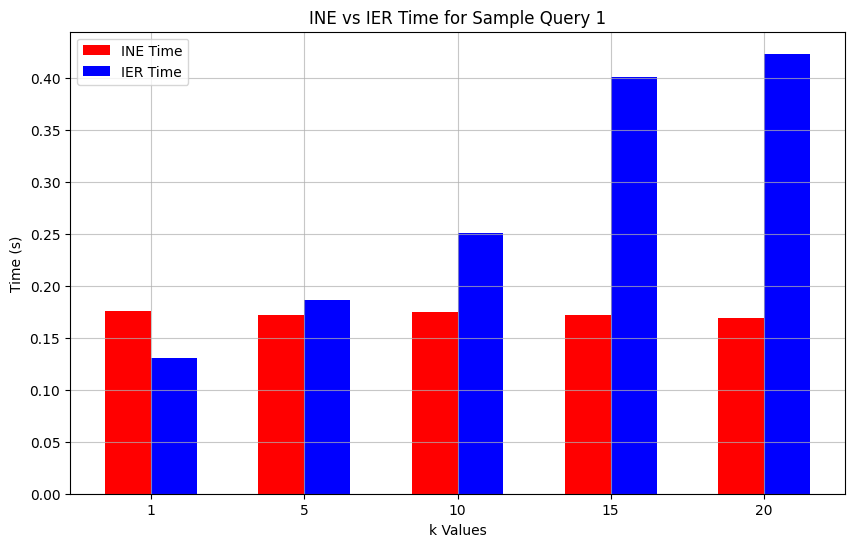

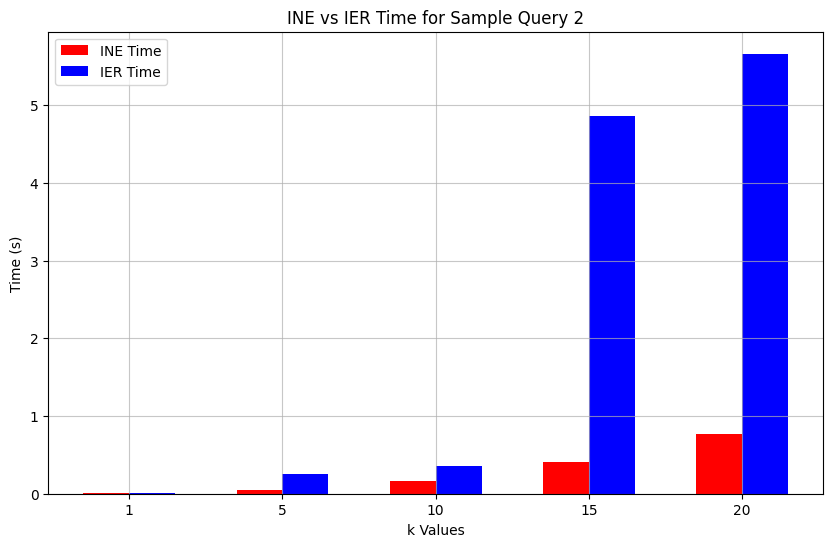

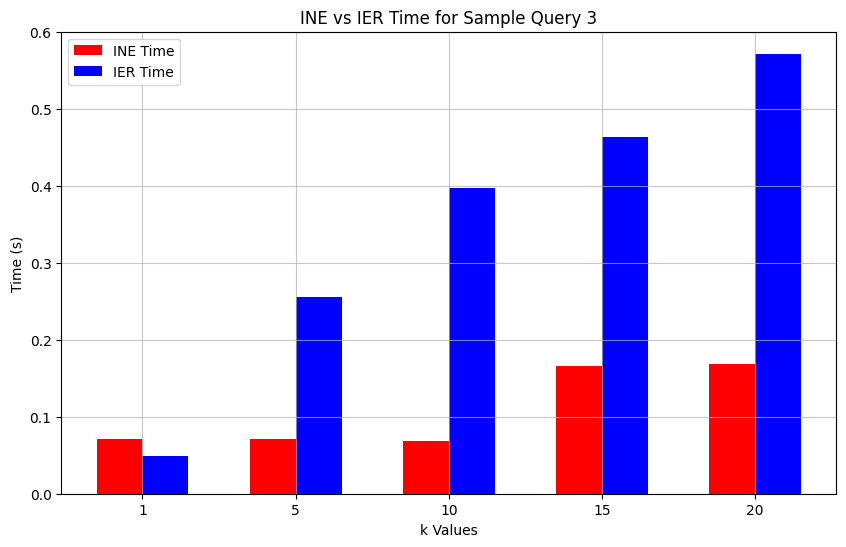

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Plot query times
for i, query in enumerate(sample_queries):
    query_label = f'Sample Query {i+1}'
    query_results = results_df[results_df['Query'] == query_label]
    
    ine_times = query_results['INE Time'].values
    ier_times = query_results['IER Time'].values
    
    x = np.arange(len(k_values))  
    width = 0.3 

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, ine_times, width, label='INE Time', color='red')
    bars2 = ax.bar(x + width/2, ier_times, width, label='IER Time', color='blue')

    ax.set_xlabel('k Values')
    ax.set_ylabel('Time (s)')
    ax.set_title(f'INE vs IER Time for {query_label}')
    ax.set_xticks(x)
    ax.set_xticklabels(k_values)
    ax.legend()

    ax.grid(True, linestyle='-', alpha=0.7)

    plt.show()

## 7- Observations


In the analysis section, three different queries were tested against IER and INE. The results of which are displayed in tables to verify that both functions are providing the same results for the queries' neighbors.

Following this are histograms representing running times for IER and INE for each query at different values of k. For the most part, INE performs better than IER, and this difference grows as values of k increase. For a k value of 1 in queries 1 and 3, IER performs better; The reasoning could be due to Euclidean distance being a good estimate for network distance in these cases. Such a scenario could be when the neighbor POIs fall on the same segment. 

The trends found in this assignment align with those of the paper; INE is a faster algorithm for querying nearest neighbors in a network.

Some challenges were faced when using the initial buffer dT = 10 in the INE algorithm, this would lead to some POIs not being identified on the segment, leading to incorrect results. Increasing this threshold yielded better results, however, it is a parameter that needs fine-tuning dependent on information of the underlying network.

